In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
data_dir = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\Rice_Image_Dataset'

In [5]:
os.listdir(data_dir)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [6]:
rice_img_path = data_dir+'\\Basmati\\'

In [7]:
from PIL import Image

def count_images(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.jpg'):
            count += 1
    return count

def analyze_images(folder_path):
    sizes = []
    mean_colors = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                # Get image size
                width, height = img.size
                sizes.append((width, height))
                
                # Convert image to numpy array
                img_array = np.array(img)
                
                # Calculate mean color
                mean_color = img_array.mean(axis=(0, 1))
                mean_colors.append(mean_color)

    return sizes, mean_colors

def plot_distribution(sizes, mean_colors):
    # Plot size distribution
    widths, heights = zip(*sizes)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, alpha=0.7, label='Width')
    plt.hist(heights, bins=20, alpha=0.7, label='Height')
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.title('Image Size Distribution')
    plt.legend()

    # Plot color distribution
    mean_colors = np.array(mean_colors)
    plt.subplot(1, 2, 2)
    plt.hist(mean_colors[:, 0], bins=20, alpha=0.7, label='Red', color='red')
    plt.hist(mean_colors[:, 1], bins=20, alpha=0.7, label='Green', color='green')
    plt.hist(mean_colors[:, 2], bins=20, alpha=0.7, label='Blue', color='blue')
    plt.xlabel('Mean Color Value')
    plt.ylabel('Frequency')
    plt.title('Color Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()


Total number of JPG images: 15000


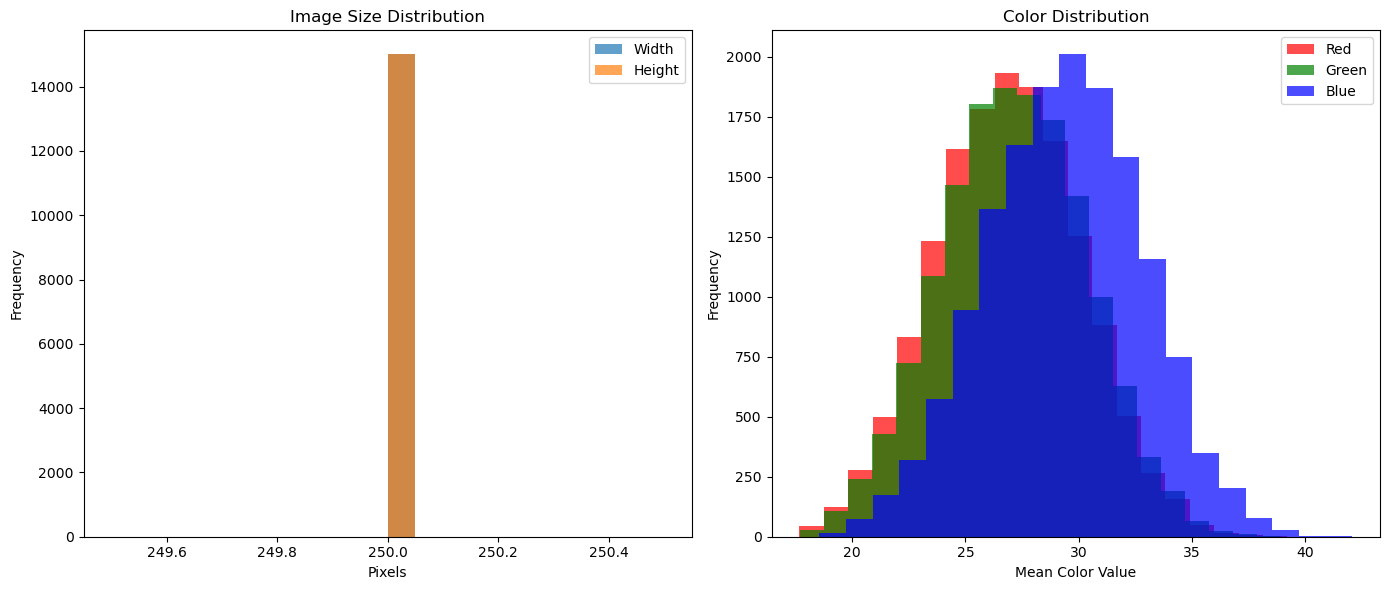

In [8]:
# Count the number of images
image_count = count_images(rice_img_path)
print(f'Total number of JPG images: {image_count}')

sizes, mean_colors = analyze_images(rice_img_path)
plot_distribution(sizes, mean_colors)

In [9]:
# Image dimensions
img_height, img_width = 250, 250
rescale_height, rescale_width = 56, 56
channels = 3  # RGB images

In [10]:
def load_and_preprocess_images(folder_path, img_height=56, img_width=56):
    images = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                # Convert to grayscale
                img = img.convert('L')
                # Resize image
                img = img.resize((img_width, img_height))
                # Convert to numpy array
                img_array = np.array(img)
                # Normalize the images to the range [-1, 1]
                img_array = (img_array - 127.5) / 127.5
                images.append(img_array)

    images = np.expand_dims(np.array(images), axis=-1)  # Expand dimensions to add channel for grayscale

    # Convert to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

    # Apply data augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.RandomRotation(0.2),
    ])

    augmented_images = data_augmentation(images_tensor)
    
    return augmented_images.numpy()

In [11]:
# Load and preprocess images
images = load_and_preprocess_images(rice_img_path)

In [12]:
images.shape

(15000, 56, 56, 1)

In [13]:
def plot_images(images, num_images=5, title="Title"):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

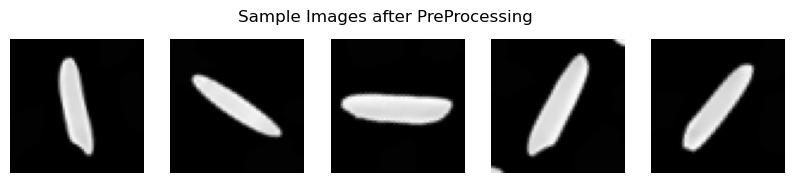

In [14]:
plot_images(images, title="Sample Images after Preprocessing")

## Generator and Discriminator

In [16]:
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from scipy.linalg import sqrtm

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
codings_size = 100

In [40]:
def calculate_fid(real_images, generated_images):
    """Calculate the FID score for grayscale images."""
    # Resize images to (75, 75)
    real_images_resized = tf.image.resize(real_images, (75, 75)).numpy()
    generated_images_resized = tf.image.resize(generated_images, (75, 75)).numpy()
    
    # Convert grayscale to RGB
    real_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(real_images_resized))
    generated_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(generated_images_resized))
    
    # Scale images to [0, 255]
    real_images_rescaled = (real_images_rgb * 127.5 + 127.5).numpy().astype('float32')
    generated_images_rescaled = (generated_images_rgb * 127.5 + 127.5).numpy().astype('float32')
    
    # Calculate activations
    model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3), weights=None)
    act1 = model.predict(real_images_rescaled)
    act2 = model.predict(generated_images_rescaled)
    
    # Calculate mean and covariance
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    # Calculate FID score
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

In [20]:
generator = Sequential()
generator.add(Dense(14 * 14 * 128, input_shape=[codings_size]))
generator.add(Reshape([14, 14, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())
# Adjusted Conv2DTranspose to output 56x56x1 images
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))

generator.summary()

C:\Users\kaizi\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 25088)               │       2,533,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 28, 28, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 56, 56, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,741,121 (10.46 MB)

 Trainable params: 2,740,737 (10.46 MB)

 Non-trainable params: 384 (1.50 KB)

In [21]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                         activation=LeakyReLU(0.3),
                         input_shape=[56, 56, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                         activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

C:\Users\kaizi\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,681 (905.00 KB)

 Trainable params: 231,681 (905.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
GAN = Sequential([generator, discriminator])
     
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False
     
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [23]:
GAN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ ?                           │       2,741,121 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ ?                           │         231,681 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,972,802 (11.34 MB)

 Trainable params: 2,740,737 (10.46 MB)

 Non-trainable params: 232,065 (906.50 KB)

In [36]:
# Training the GAN
batch_size = 32

In [25]:
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(buffer_size=1000)

In [27]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

### Training

In [42]:
epochs = 2
fid_scores = []
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tTraining on batch number {i} of {len(images)//batch_size}")
        
        ## TRAINING DISCRIMINATOR
       
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Generate numbers based just on noise input
        gen_images = generator(noise)

        # Concatenate Generated Images against the Real Ones
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)

        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

        discriminator.trainable = True

        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)

        ## TRAINING GENERATOR   

        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Allow discriminator to believe that fake images are real
        y2 = tf.constant([[1.]] * batch_size)

        discriminator.trainable = False

        GAN.train_on_batch(noise, y2)
    
    # Evaluate FID
    noise = tf.random.normal(shape=[1000, codings_size])
    generated_images = generator(noise)
    real_images = next(iter(dataset))[:1000]

    fid = calculate_fid(real_images, generated_images)
    fid_scores.append(fid)
    print(f"Epoch {epoch+1} FID: {fid}")
    
print("COMPLETED")

Currently on Epoch 1
	Training on batch number 20 of 468
	Training on batch number 40 of 468
	Training on batch number 60 of 468
	Training on batch number 80 of 468
	Training on batch number 100 of 468
	Training on batch number 120 of 468
	Training on batch number 140 of 468
	Training on batch number 160 of 468
	Training on batch number 180 of 468
	Training on batch number 200 of 468
	Training on batch number 220 of 468
	Training on batch number 240 of 468
	Training on batch number 260 of 468
	Training on batch number 280 of 468
	Training on batch number 300 of 468
	Training on batch number 320 of 468
	Training on batch number 340 of 468
	Training on batch number 360 of 468
	Training on batch number 380 of 468
	Training on batch number 400 of 468
	Training on batch number 420 of 468
	Training on batch number 440 of 468
	Training on batch number 460 of 468
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step
Epoch 1 FID: 0.08125193052468463
Currently on Epoch 2


In [43]:
def plot_fid():
    # Plot FID scores vs epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), fid_scores, marker='o', linestyle='-', color='b')
    plt.title('FID Scores over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('FID Score')
    plt.grid(True)
    plt.show()

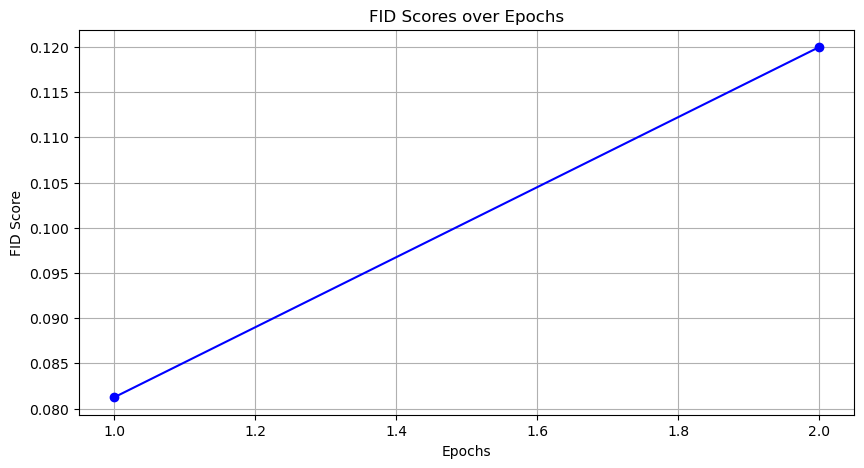

In [44]:
plot_fid()

In [45]:
def plot_gen_images(images, num_images=5, title='Generated Images', save_path=None):
    num_cols = 7  # Number of images per row
    num_rows = (num_images - 1) // num_cols + 1  # Calculate number of rows needed
    
    plt.figure(figsize=(15, num_rows * 3))  # Adjusted size for better visibility
    for i in range(num_images):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        # Convert tensor to numpy array and squeeze to remove extra dimensions
        image = images[i].numpy().squeeze()
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
        # Save the individual image if save_path is provided
        if save_path:
            plt.imsave(os.path.join(save_path, f'image_{i}.png'), image, cmap='gray')
    
    plt.suptitle(title)
    plt.show()

In [46]:
def generate_and_plot_images(generator, codings_size, num_images=20, save_images=False, save_path=None):
    noise = tf.random.normal(shape=[num_images, codings_size])
    gen_images = generator(noise)
    
    if save_images and save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
    
    plot_gen_images(gen_images, num_images, title='Generated Images after Training', save_path=save_path)

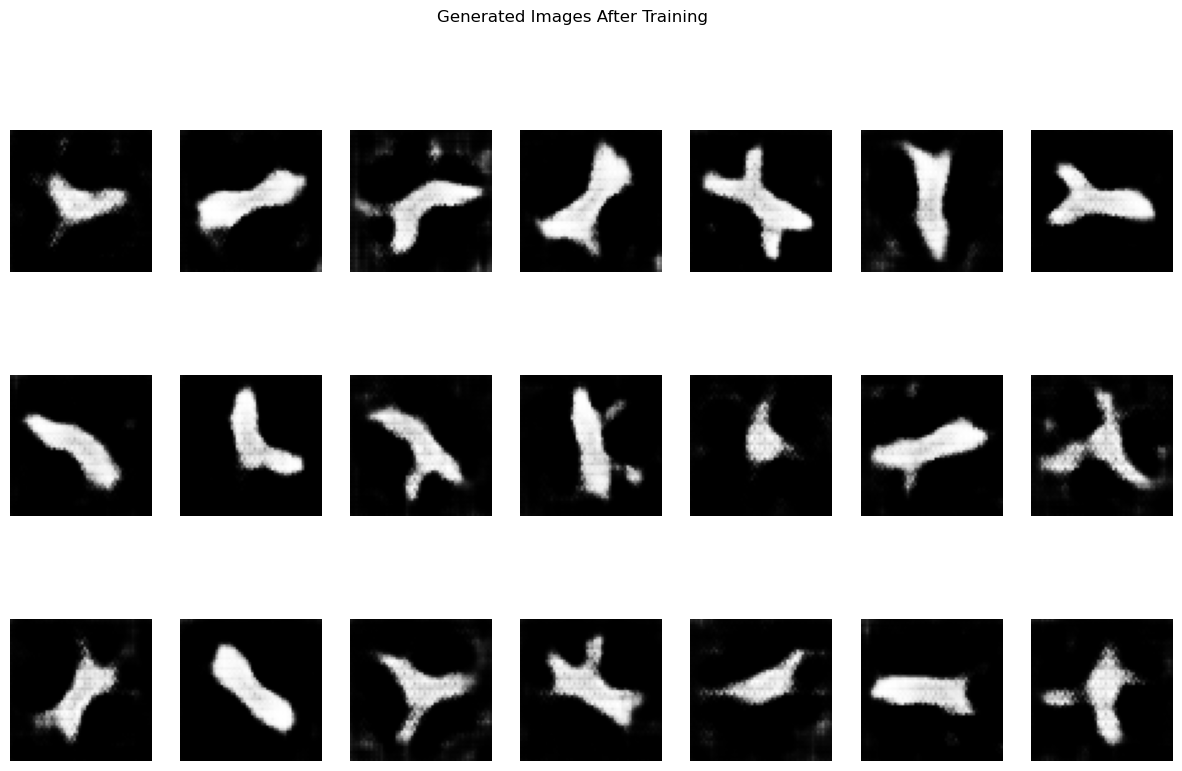

In [48]:
# Generate and save images
save_path = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\Fake_Rice_Images\\Basmati'
generate_and_plot_images(generator, codings_size, num_images=21, save_images=True, save_path=save_path)